In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [104]:
LEN = 400
DIM_BEFORE_OPT = (630,210)
IMG_DIM = (210,210)

In [105]:
def getLabels(path):
    labels = []
    f = open(path,'r')
    for l in f:
        labels.append(float(l))
    labels = np.array(labels)
    return labels

def getLabelsFrom2k19(Y_path, t_path):
    values = np.load(Y_path).flatten()
    times = np.load(t_path).flatten()
    Y = []
    count = 0
    for i, t in enumerate(times):
        if float(t) - float(times[0]) > count:
            Y.append(values[i])
            count+= (1/20)
    return np.array(Y)

In [106]:
main_images = []
main_labels = getLabels("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/train.txt")[:LEN]
cap = cv2.VideoCapture("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/train.mp4")
for i in range(LEN):
    ret, frame  = cap.read()
    main_images.append(frame)

In [107]:
kitti_images = []
kitti_labels = getLabels("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/KITTI/2011_09_26_drive_0051_sync/labels.txt")
for i in range(LEN):
    path = "C:/Users/Lukas/Desktop/commaai-speed-challenge/data/KITTI/2011_09_26_drive_0051_sync/image_03/data/"+str(i).zfill(10)+".png"
    kitti_images.append(cv2.imread(path))

In [24]:
k19_images = []
path = "C:/Users/Lukas/Desktop/commaai-speed-challenge/data/2k19/Chunk_4/99c94dc769b5d96e_2018-06-15--19-55-32/6/"
k19_labels = getLabelsFrom2k19(path+"processed_log/CAN/speed/value", path+"processed_log/CAN/speed/t")
cap = cv2.VideoCapture(path+"video.hevc")
for i in range(1190):
    ret, frame  = cap.read()
    k19_images.append(frame)

In [7]:
def incVhsv(img, val=1):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] += val
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [97]:
def incContrast(img):
    alpha = 2 # 1-3
    beta = 20    # 0-100
    img=cv2.addWeighted(img,alpha,np.zeros(img.shape, img.dtype),0,beta)
    return img

In [118]:
def opticalFlow(frame1,frame2, mode):
    #frame1 = incVhsv(frame1,10)
    #frame2 = incVhsv(frame2,10)
    if mode == 0:
        pass
    if mode == 1:
        frame1 = frame1[140:350, 5:635]
        frame2 = frame2[140:350, 5:635]
        frame1 = cv2.resize(frame1, DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
        frame2 = cv2.resize(frame2, DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
        #frame1 = incContrast(frame1)
        #frame2 = incContrast(frame2)
    if mode == 2:
        frame1 = frame1[0:375, 59:1184]
        frame2 = frame2[0:375, 59:1184]
        frame1 = cv2.resize(frame1, DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
        frame2 = cv2.resize(frame2, DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
    if mode == 3:
        frame1 = frame1[213:213+382, 9:9+1146]
        frame2 = frame2[213:213+382, 9:9+1146]
        frame1 = cv2.resize(frame1, DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
        frame2 = cv2.resize(frame2, DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
        #frame1 = incContrast(frame1)
        #frame2 = incContrast(frame2)
        
    #frame1 = frame1[0:DIM_BEFORE_OPT[1], int(DIM_BEFORE_OPT[0]/3): int(2*DIM_BEFORE_OPT[0]/3)]
    #frame2 = frame2[0:DIM_BEFORE_OPT[1], int(DIM_BEFORE_OPT[0]/3): int(2*DIM_BEFORE_OPT[0]/3)]
    
    flow = np.zeros_like(frame1)
    frame1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow_data = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.4, 1, 12, 2, 8, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow_data[...,0], flow_data[...,1])
    mag = (mag *15).astype(int)
    
    mag[mag>255] = 255
    
    print("mean",mag.mean())
    
    #plt.plot(mag,'r-')
    
    #plt.show()
    
    ang = ang*180/np.pi/2
    flow[...,1] = 255
    flow[...,0] = ang
    flow[...,2] = mag
    flow = cv2.resize(flow, IMG_DIM, interpolation = cv2.INTER_AREA)
    return flow

mean 12.654784580498866


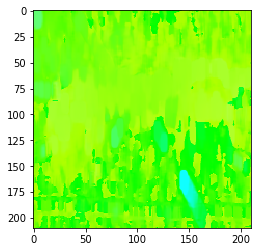

19.452522
mean 27.670733182161754


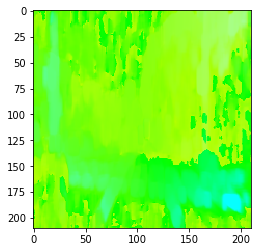

10.712500000000002
mean -16211.718374905518


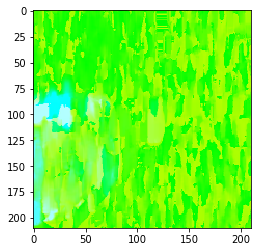

-0.0097787587234116


In [119]:
number = 300

#
plt.imshow(opticalFlow(main_images[number],main_images[number+1],1), interpolation='nearest')
plt.show()
print(main_labels[number])


plt.imshow(opticalFlow(k19_images[number],k19_images[number+1],3), interpolation='nearest')
plt.show()
print(k19_labels[number])



plt.imshow(opticalFlow(kitti_images[number],kitti_images[number+1],2), interpolation='nearest')
plt.show()
print(kitti_labels[number])

In [18]:
print(main_images[0].shape, kitti_images[0].shape, k19_images[0].shape) 

(480, 640, 3) (375, 1242, 3) (874, 1164, 3)


In [11]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

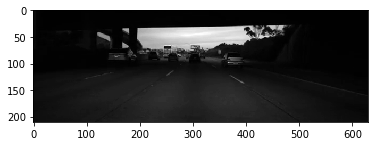

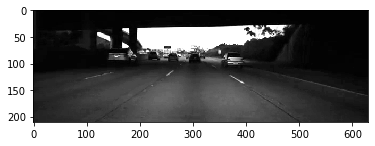

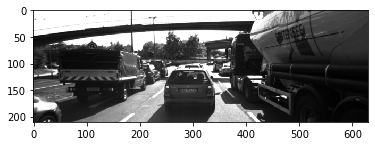

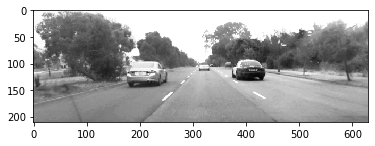

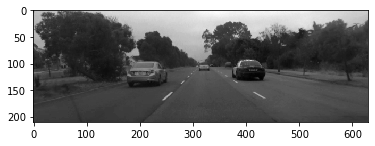

In [96]:
#IDEAL augmentation

color = 6
number = 19

main_frame = cv2.resize(main_images[number][140:350, 5:635], DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
#main_frame = incVhsv(main_frame,1)
main_frame = cv2.cvtColor(main_frame, color)
plt.imshow(main_frame, interpolation='nearest', cmap="gray")
plt.show()


main_frame = cv2.resize(main_images[number][140:350, 5:635], DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
main_frame = incContrast(main_frame)

main_frame = cv2.cvtColor(main_frame, color)
plt.imshow(main_frame, interpolation='nearest', cmap="gray")
plt.show()



kitti_frame = cv2.resize(kitti_images[number][0:375, 59:1184], DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
kitti_frame = cv2.cvtColor(kitti_frame, color)
plt.imshow(kitti_frame, interpolation='nearest', cmap="gray")
plt.show()

k19_frame = cv2.resize(k19_images[number+1100][213:213+382, 9:9+1146], DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
k19_frame = incContrast(k19_frame)
k19_frame = cv2.cvtColor(k19_frame, color)
plt.imshow(k19_frame, interpolation='nearest', cmap="gray")
plt.show()

k19_frame = cv2.resize(k19_images[number+1100][213:213+382, 9:9+1146], DIM_BEFORE_OPT, interpolation = cv2.INTER_AREA)
k19_frame = cv2.cvtColor(k19_frame, color)
plt.imshow(k19_frame, interpolation='nearest', cmap="gray")
plt.show()

